# ตอนที่ 1: การทดลองเตรียมข้อมูล ปรับค่าข้อมูล และจัดแบ่งชุด Train, Test เพื่อสอนโมเดล

1.1 Import Lib (numpy, pandas, matplotlib, sklearn, keras)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from sklearn import model_selection
from sklearn import preprocessing
import seaborn as sns

Using TensorFlow backend.


1.2 โหลดข้อมูล Timeseries Dataset file

In [2]:
df_Beijing = pd.read_csv('BeijingPM20100101_20151231.csv')
df_Chengdu = pd.read_csv('ChengduPM20100101_20151231.csv')
df_Guangzhou = pd.read_csv('GuangzhouPM20100101_20151231.csv')
df_Shanghai = pd.read_csv('ShanghaiPM20100101_20151231.csv')
df_Shenyang = pd.read_csv('ShenyangPM20100101_20151231.csv')

1.3 Preprocess data

    1.3.1 Cleaning : Clear Missing and Duplicate data, Resampling and interpolated data, Moving average (Rolling window)

    1.3.2 แสดงรูปภาพเปรียบเทียบข้อมูลก่อนและหลัง Cleaning

In [3]:
def pm2_5_level(df):
    if df['PM_US Post']<10:
        return 0
    elif df['PM_US Post'] <= 25:
        return 1
    elif df['PM_US Post'] > 25:
        return 2
    else: 
        return np.nan

In [4]:
def show_graph(msg,df,setX=True):
    hist = df.hist(bins=8,figsize=(10,10))
    
    axes = df.plot.line(x='Date',subplots=True, figsize=(16, 16),title=msg)
    
    list_of_cmaps=['Blues','Greens','Reds','Purples']
    
    g = sns.PairGrid(df ,hue='PM2.5_level', hue_kws={"cmap":list_of_cmaps},)
    g.map_upper(plt.scatter)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.distplot)
    g.add_legend()

In [5]:
def before_cleaning(data):
    start_col=['year','month','day','hour','HUMI','PRES','Iws','Iprec','PM_US Post']
    df = pd.DataFrame(data,columns=start_col)
    
    df['Date'] = pd.to_datetime(df[['year','month','day','hour']])
    df.sort_values('Date', inplace=True)
    
    df.dropna(subset=['PM_US Post'],inplace=True) # drop pm 2.5 missing values
    df['PM2.5_level'] = df.apply(lambda df:pm2_5_level(df),axis=1) # add col 'PM2.5_level'
    
    df = df[['Date','HUMI','PRES','Iws','Iprec','PM_US Post','PM2.5_level']]
    _df = df.copy()
    
    _df.dropna(inplace=True)
    
    show_graph(msg='Before',df=_df)
    
    return df

In [6]:
def clear_missing_and_duplicate_data(df):
    
    df[df.columns[1:4]] = df[df.columns[1:4]].apply(pd.to_numeric, errors='coerce')
    
    df = df.fillna(df.median()) # จัดการข้อมูลหาย แทนที่ด้วย median
    df = df.drop_duplicates()
    
    return df

In [7]:
def find_timediff(df):
    df['timediff'] = (df['Date']-df['Date'].shift().shift()).fillna(0)
    print('median timediff : ',df['timediff'].median())
    return df

In [8]:
def resample_rolling(df,resample='2H'):
    
    df = df.set_index('Date').resample(resample).mean()
    df.sort_values('Date', inplace=True)
    
    df.interpolate(inplace=True)
    df = df.rolling(5).mean()
    
    df = df.reset_index()
    df = df.iloc[4:,:6]
    
    df['PM2.5_level'] = df.apply(lambda df:pm2_5_level(df),axis=1).astype(np.uint8)
    
    df = df[['Date','HUMI','PRES','Iws','Iprec','PM_US Post','PM2.5_level']]

    show_graph(msg="After",df=df,setX=False)
    return df

C:\Users\beamconan\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
C:\Users\beamconan\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
C:\Users\beamconan\Anaconda3\lib\site-packages\statsmodels\nonparametric\_kernel_base.py:516: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
C:\Users\beamconan\Anaconda3\lib\site-packages\matplotlib\contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\beamconan\Anaconda3\lib\site-packages\matplotlib\contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
C:\Users\beamconan\Anaconda3\lib\

,Date,HUMI,PRES,Iws,Iprec,PM_US Post,PM2.5_level
23,2010-01-01 23:00:00,41.0,1020.0,0.89,0.0,129.0,2
24,2010-01-02 00:00:00,38.0,1020.0,1.79,0.0,148.0,2
25,2010-01-02 01:00:00,42.0,1020.0,2.68,0.0,159.0,2
26,2010-01-02 02:00:00,63.5,1021.0,3.57,0.0,181.0,2
27,2010-01-02 03:00:00,85.0,1022.0,5.36,0.0,138.0,2
...,...,...,...,...,...,...,...
52579,2015-12-31 19:00:00,68.0,1031.0,7.14,0.0,133.0,2
52580,2015-12-31 20:00:00,63.0,1030.0,8.03,0.0,169.0,2
52581,2015-12-31 21:00:00,73.0,1030.0,0.89,0.0,203.0,2
52582,2015-12-31 22:00:00,73.0,1030.0,1.78,0.0,212.0,2


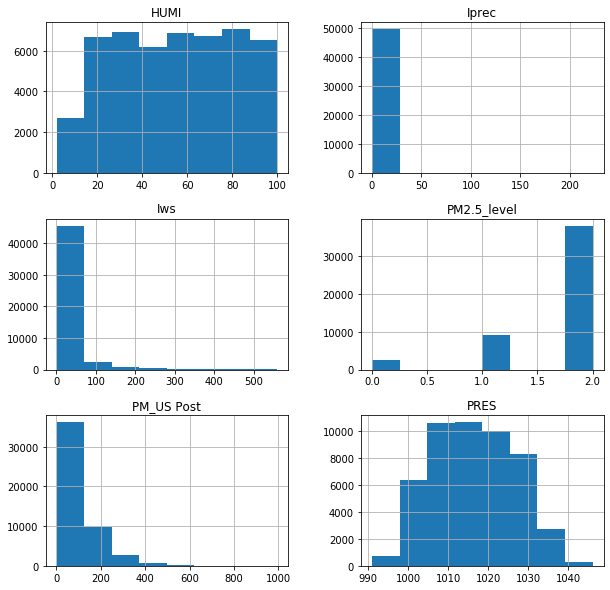

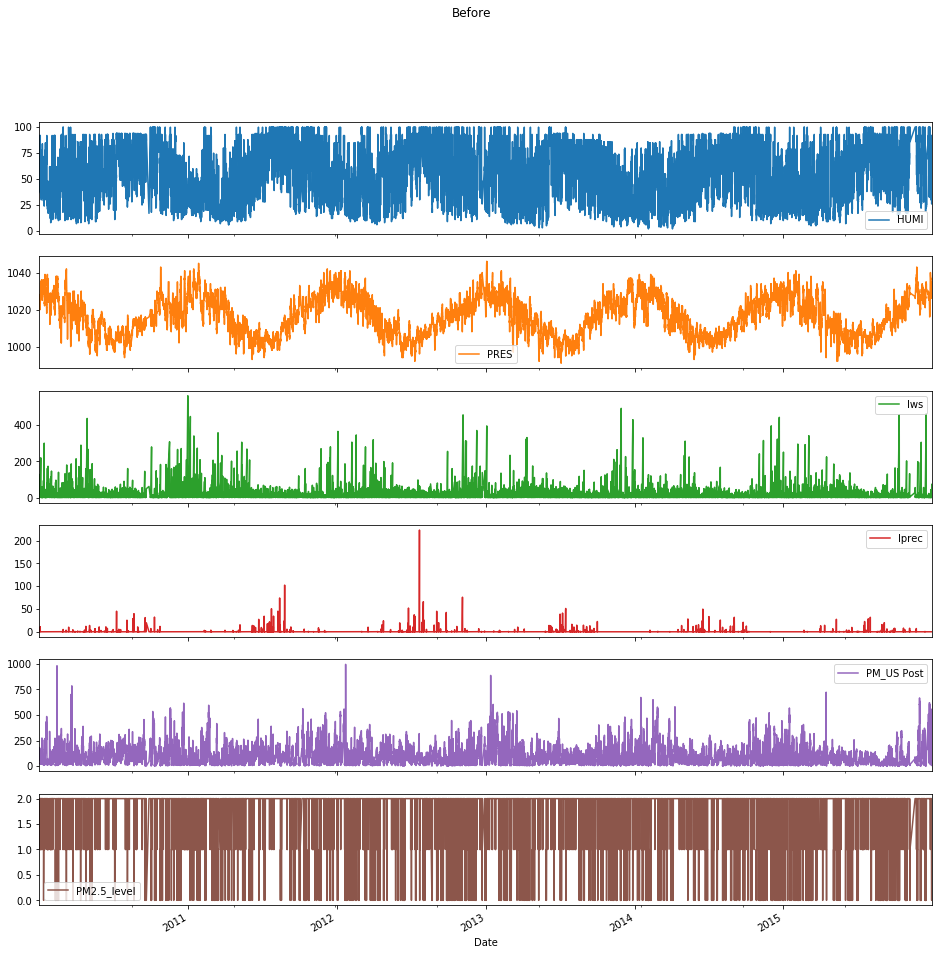

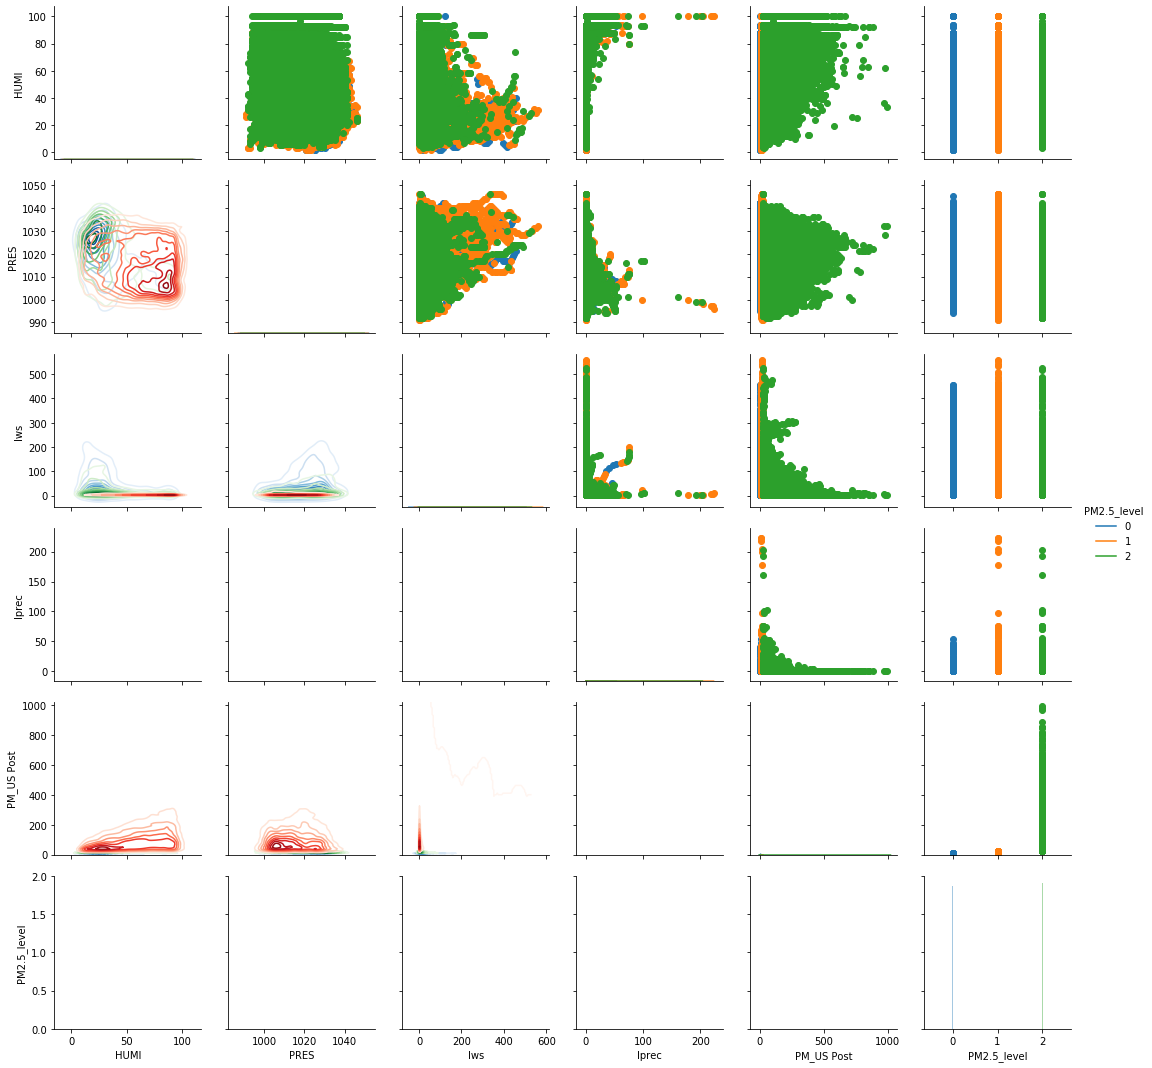

In [9]:
df1 = before_cleaning(data=df_Beijing)
df1

In [10]:
df1 = clear_missing_and_duplicate_data(df=df1)
df1

,Date,HUMI,PRES,Iws,Iprec,PM_US Post,PM2.5_level
23,2010-01-01 23:00:00,41.0,1020.0,0.89,0.0,129.0,2
24,2010-01-02 00:00:00,38.0,1020.0,1.79,0.0,148.0,2
25,2010-01-02 01:00:00,42.0,1020.0,2.68,0.0,159.0,2
26,2010-01-02 02:00:00,63.5,1021.0,3.57,0.0,181.0,2
27,2010-01-02 03:00:00,85.0,1022.0,5.36,0.0,138.0,2
...,...,...,...,...,...,...,...
52579,2015-12-31 19:00:00,68.0,1031.0,7.14,0.0,133.0,2
52580,2015-12-31 20:00:00,63.0,1030.0,8.03,0.0,169.0,2
52581,2015-12-31 21:00:00,73.0,1030.0,0.89,0.0,203.0,2
52582,2015-12-31 22:00:00,73.0,1030.0,1.78,0.0,212.0,2


,Date,HUMI,PRES,Iws,Iprec,PM_US Post,PM2.5_level
4,2010-01-02 06:00:00,66.45,1021.4,4.822,0.0,134.2,2
5,2010-01-02 08:00:00,75.25,1022.3,7.325,0.0,135.6,2
6,2010-01-02 10:00:00,83.65,1023.5,10.677,0.0,134.9,2
7,2010-01-02 12:00:00,84.60,1024.3,14.924,0.0,135.2,2
8,2010-01-02 14:00:00,81.50,1024.9,20.333,0.0,145.1,2
...,...,...,...,...,...,...,...
26276,2015-12-31 14:00:00,51.10,1033.4,13.956,0.0,34.0,2
26277,2015-12-31 16:00:00,44.60,1032.7,11.584,0.0,45.6,2
26278,2015-12-31 18:00:00,43.70,1031.9,8.584,0.0,65.6,2
26279,2015-12-31 20:00:00,48.00,1030.9,4.019,0.0,96.8,2


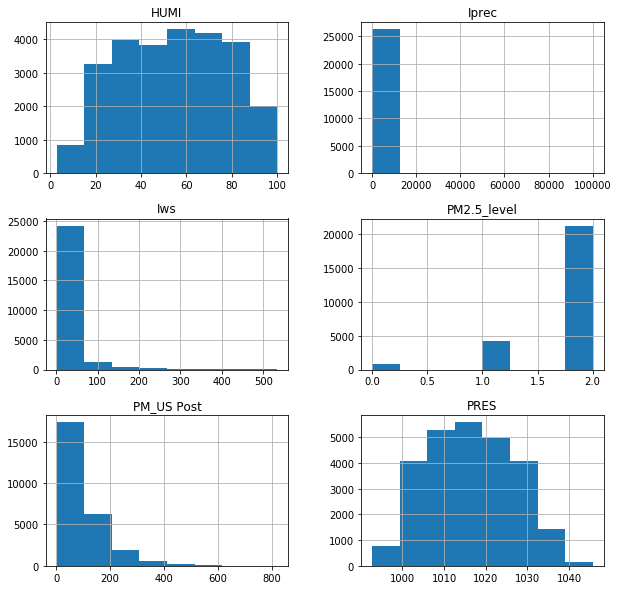

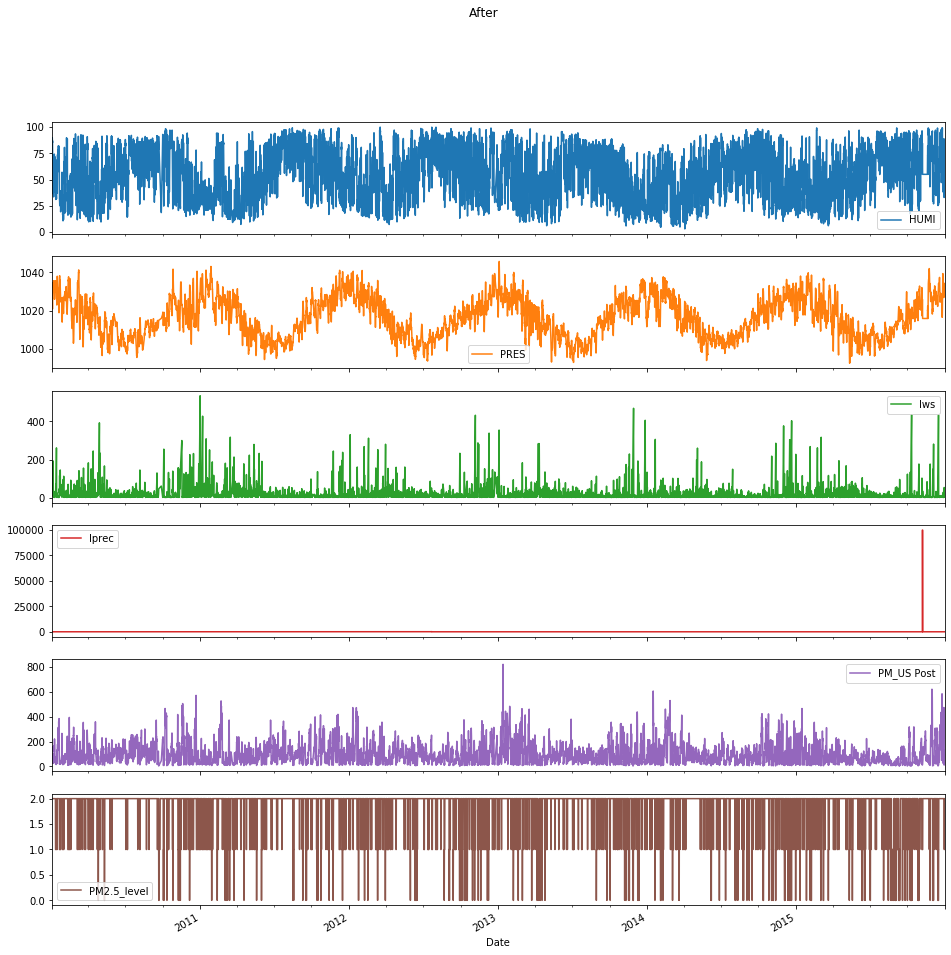

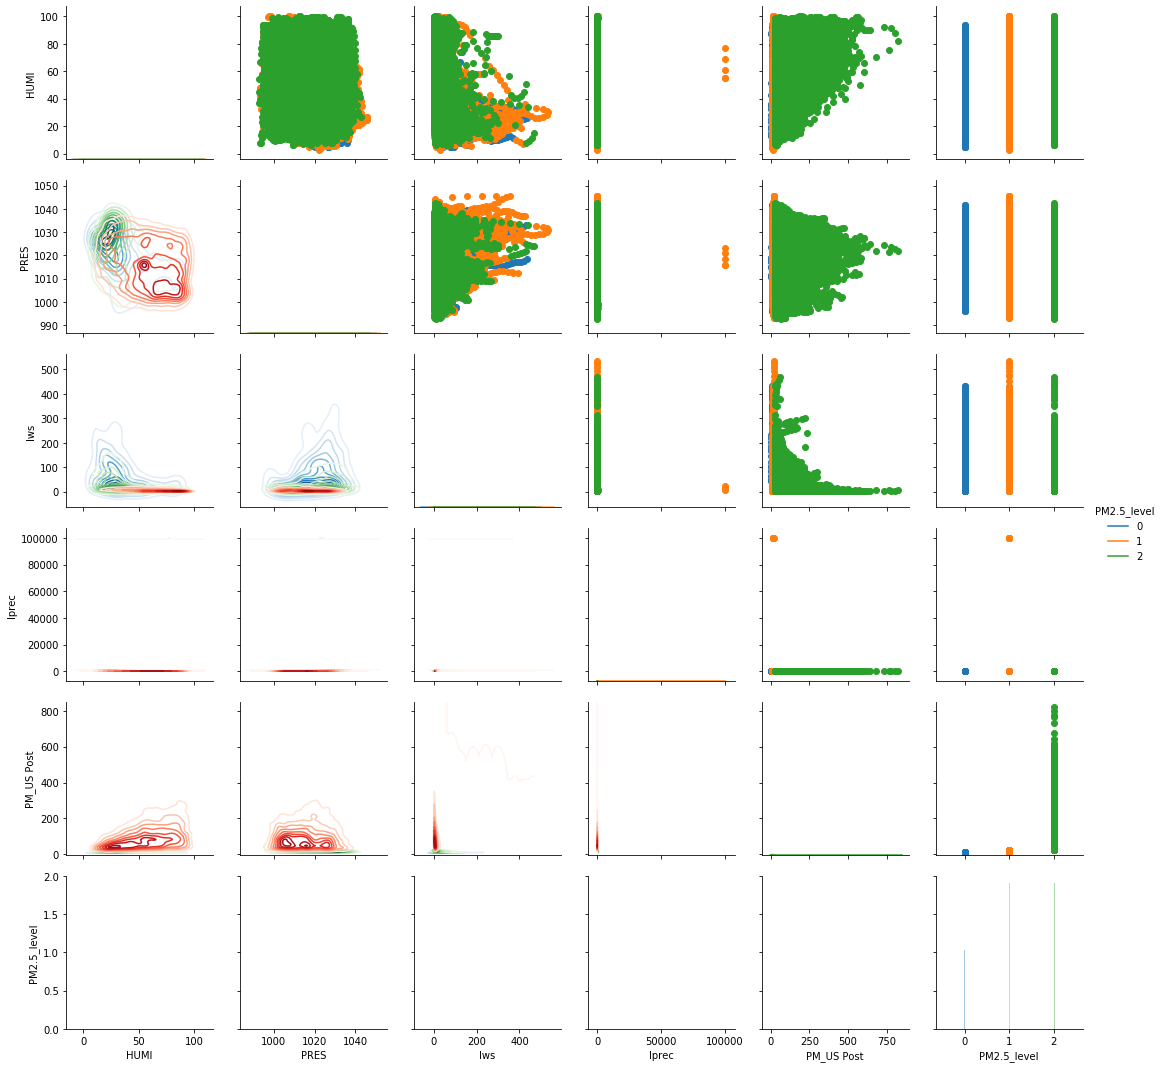

In [11]:
# find_timediff(df=df1)
df1 = resample_rolling(df=df1)
df1

,Date,HUMI,PRES,Iws,Iprec,PM_US Post,PM2.5_level
4,2012-05-14 22:00:00,24.740312,1013.854687,2.015625,0.000000e+00,46.179688,2
5,2012-05-15 00:00:00,24.990469,1013.832031,2.023438,0.000000e+00,46.269531,2
6,2012-05-15 02:00:00,25.240625,1013.809375,2.031250,0.000000e+00,46.359375,2
7,2012-05-15 04:00:00,25.490781,1013.786719,2.039062,0.000000e+00,46.449219,2
8,2012-05-15 06:00:00,25.740937,1013.764063,2.046875,0.000000e+00,46.539062,2
...,...,...,...,...,...,...,...
15912,2015-12-31 14:00:00,88.123000,1030.200000,1.300000,4.414524e-14,244.700000,2
15913,2015-12-31 16:00:00,85.579000,1029.500000,2.000000,4.414524e-14,255.300000,2
15914,2015-12-31 18:00:00,85.579000,1028.700000,2.000000,4.414524e-14,267.500000,2
15915,2015-12-31 20:00:00,85.579000,1027.900000,2.200000,4.414524e-14,266.400000,2


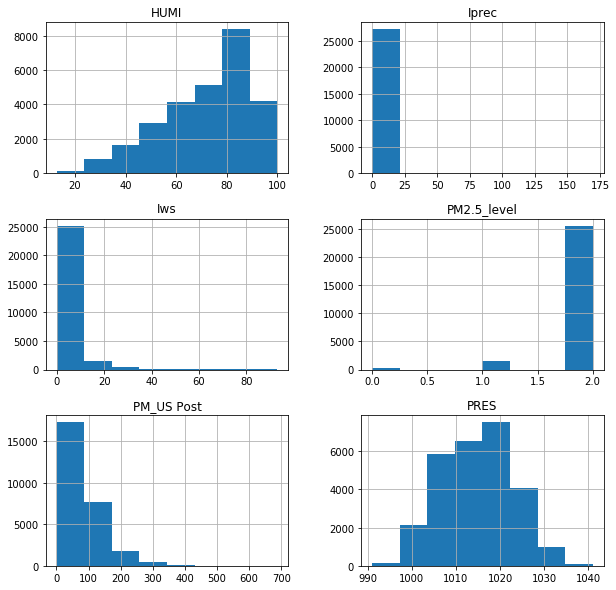

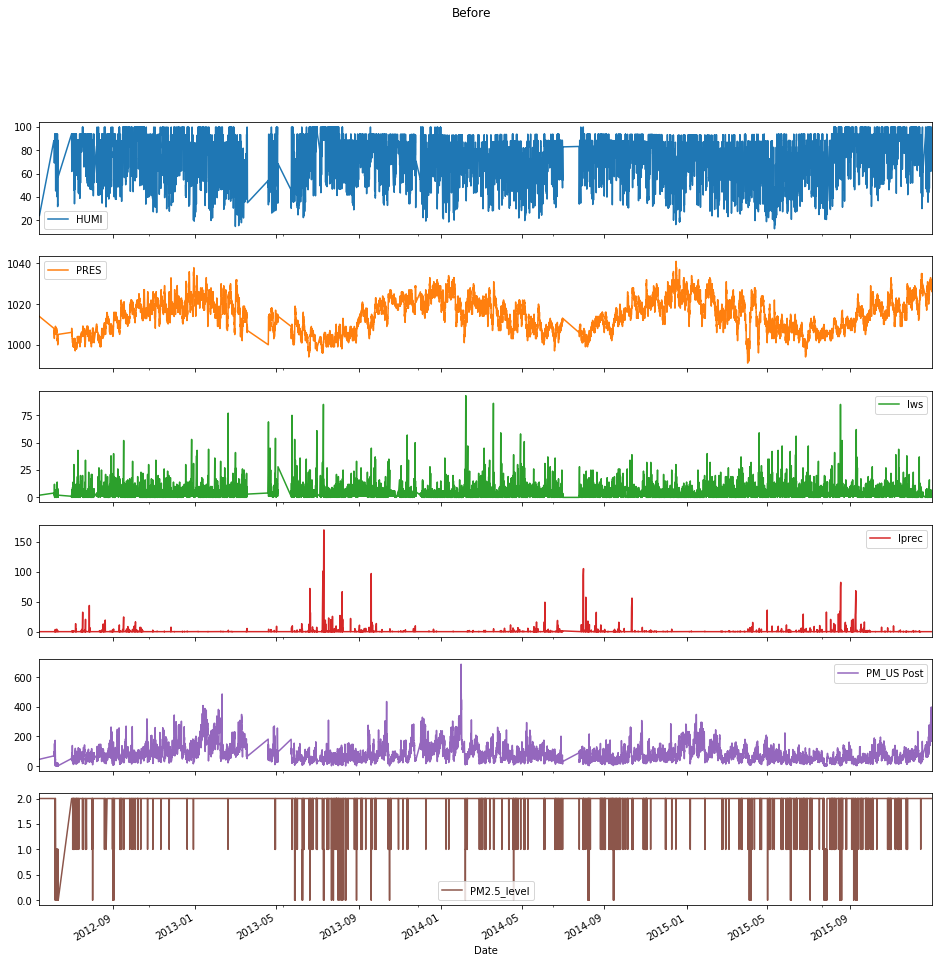

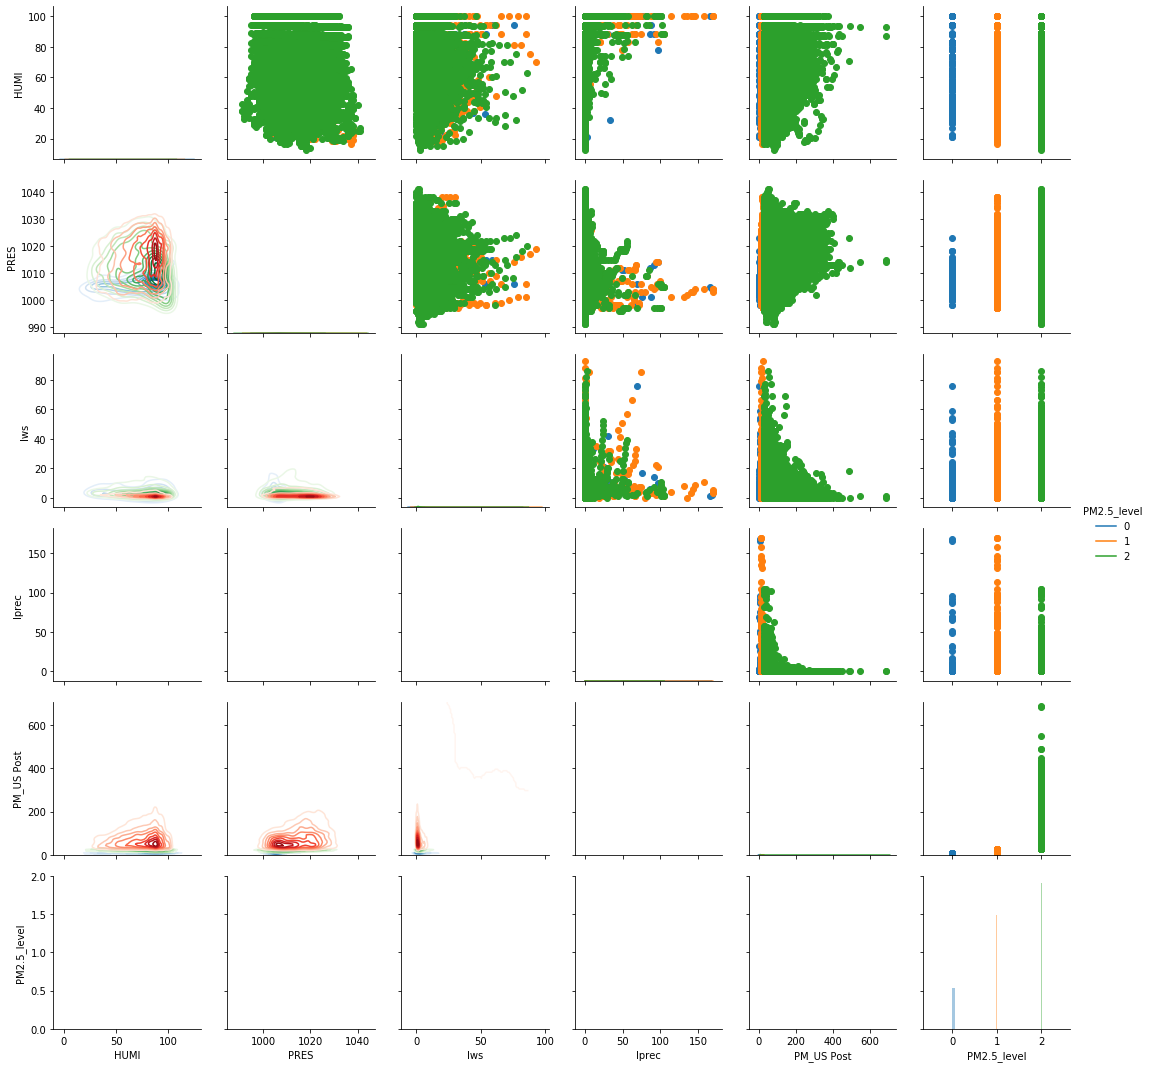

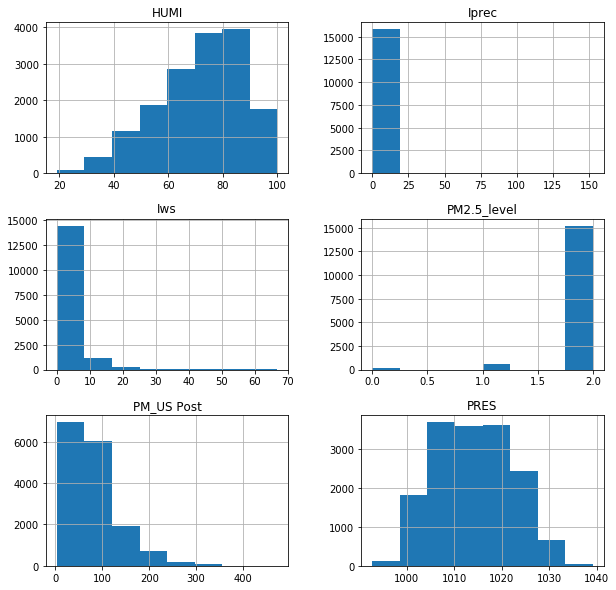

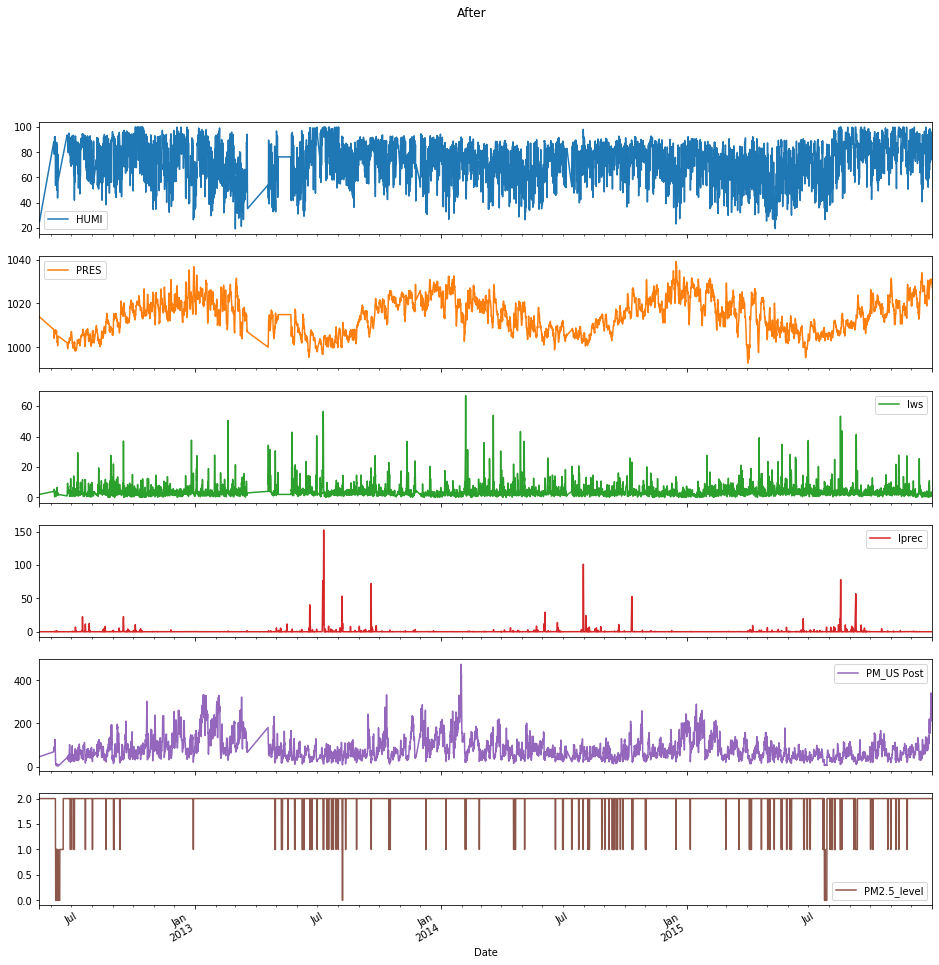

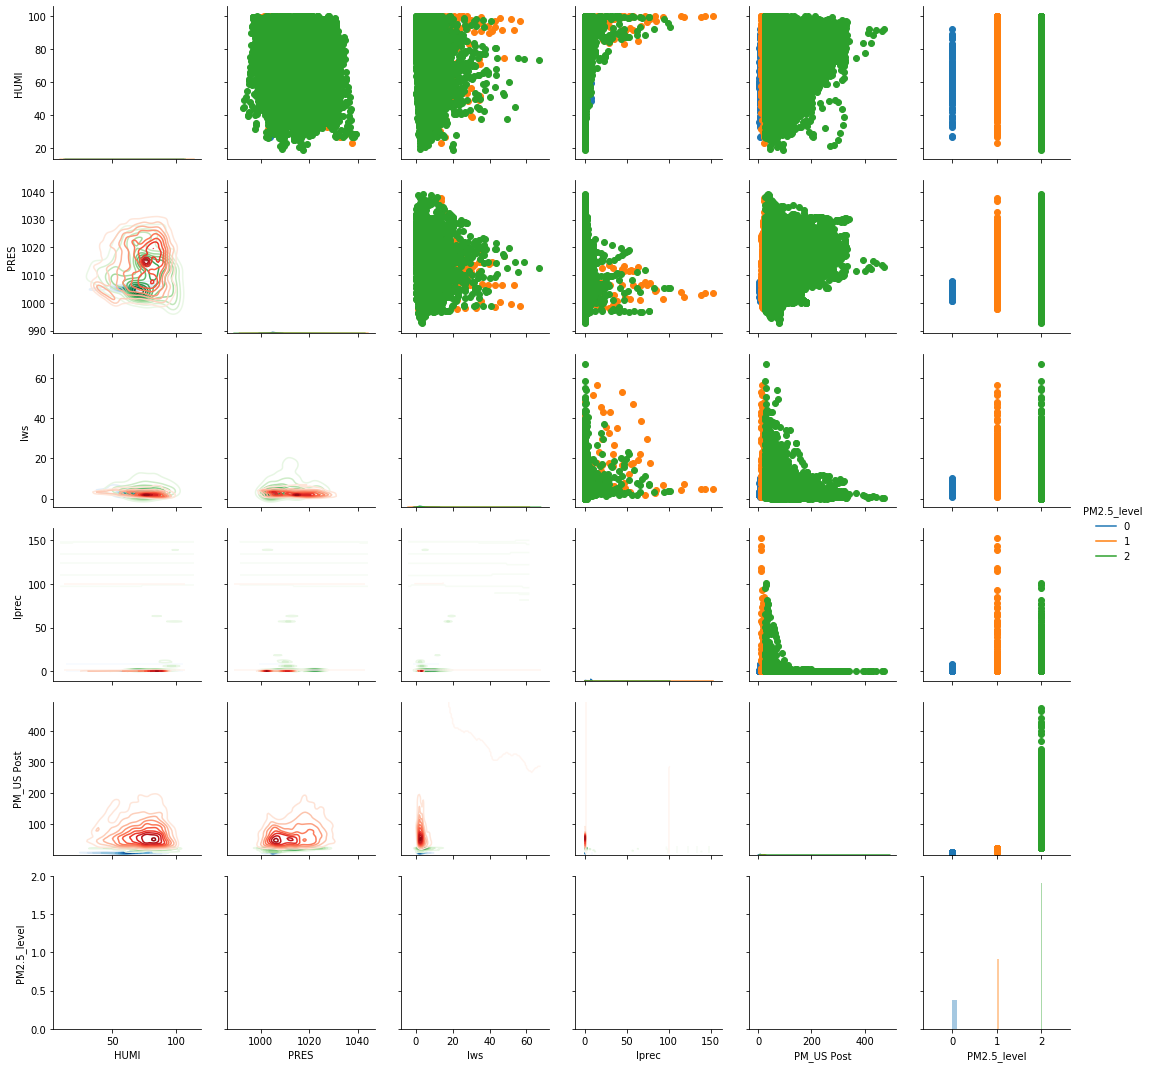

In [12]:
df2 = before_cleaning(data=df_Chengdu)
df2 = clear_missing_and_duplicate_data(df=df2)
df2 = resample_rolling(df=df2)
df2

,Date,HUMI,PRES,Iws,Iprec,PM_US Post,PM2.5_level
4,2011-11-21 20:00:00,70.2000,1012.950000,5.27000,0.000000e+00,75.00,2
5,2011-11-21 22:00:00,72.4875,1012.868750,3.64125,0.000000e+00,83.05,2
6,2011-11-22 00:00:00,73.6625,1013.056250,3.32375,0.000000e+00,86.55,2
7,2011-11-22 02:00:00,74.2250,1013.312500,3.02750,0.000000e+00,87.00,2
8,2011-11-22 04:00:00,73.3750,1013.437500,3.51250,0.000000e+00,84.50,2
...,...,...,...,...,...,...,...
18013,2015-12-31 14:00:00,63.1000,1019.439996,5.13000,3.942957e-14,51.10,2
18014,2015-12-31 16:00:00,59.6000,1019.019989,4.88000,3.942957e-14,51.80,2
18015,2015-12-31 18:00:00,60.4000,1018.499994,6.13000,3.942957e-14,52.10,2
18016,2015-12-31 20:00:00,63.5000,1018.079994,7.64000,3.942957e-14,53.30,2


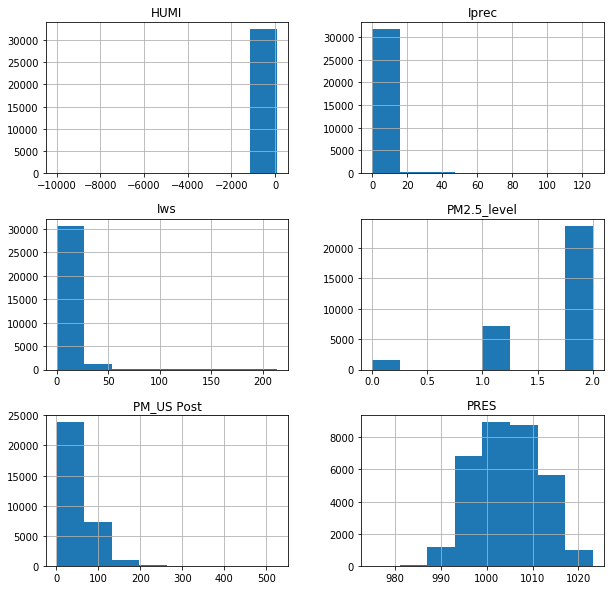

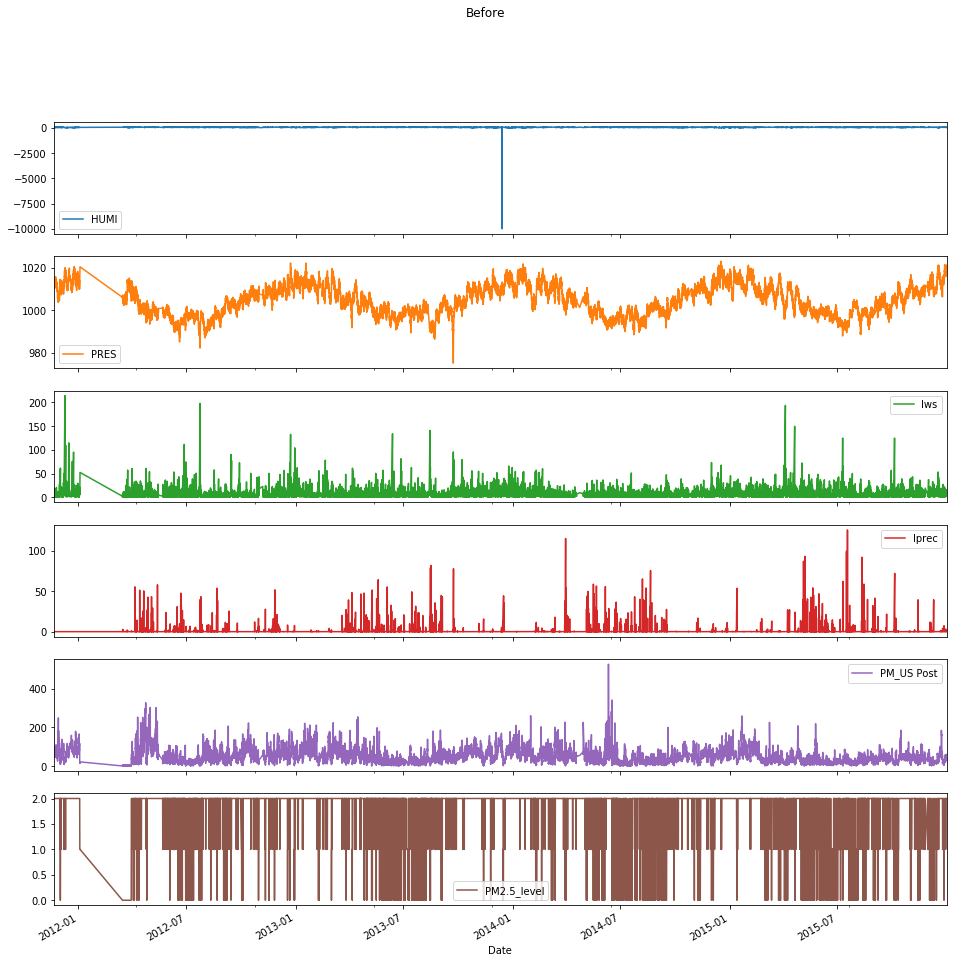

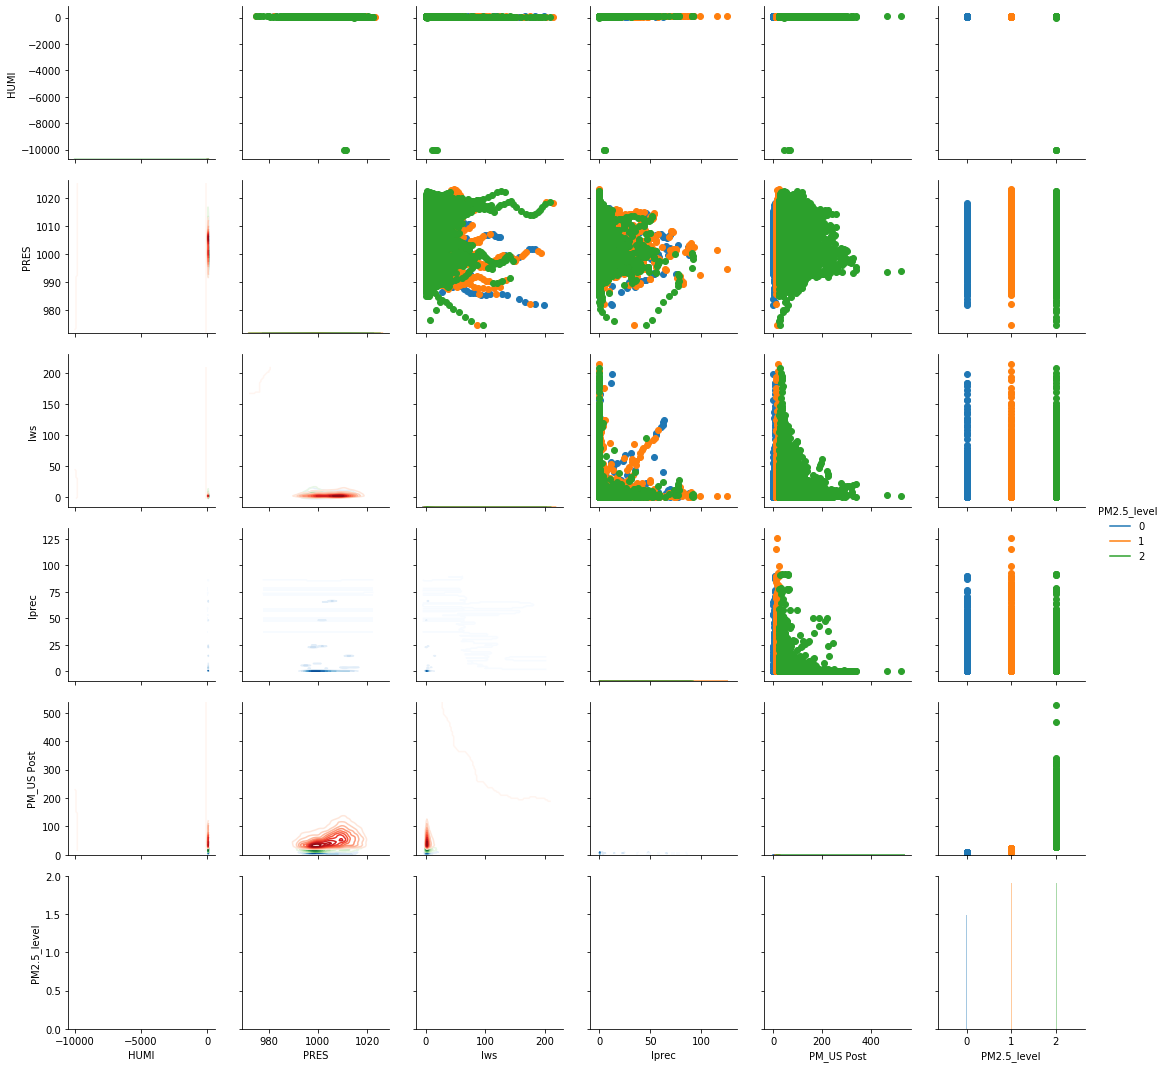

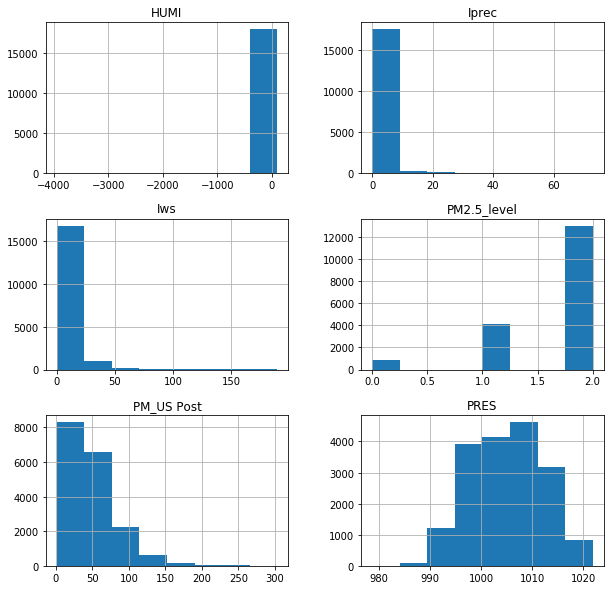

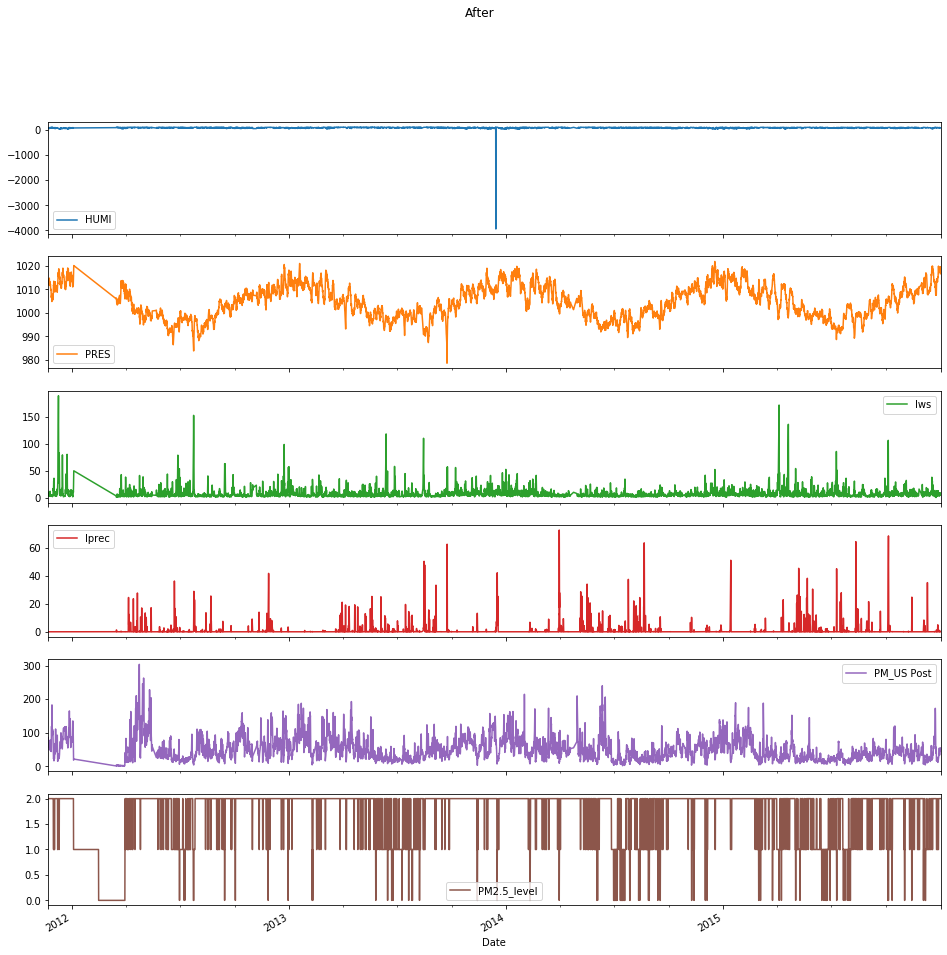

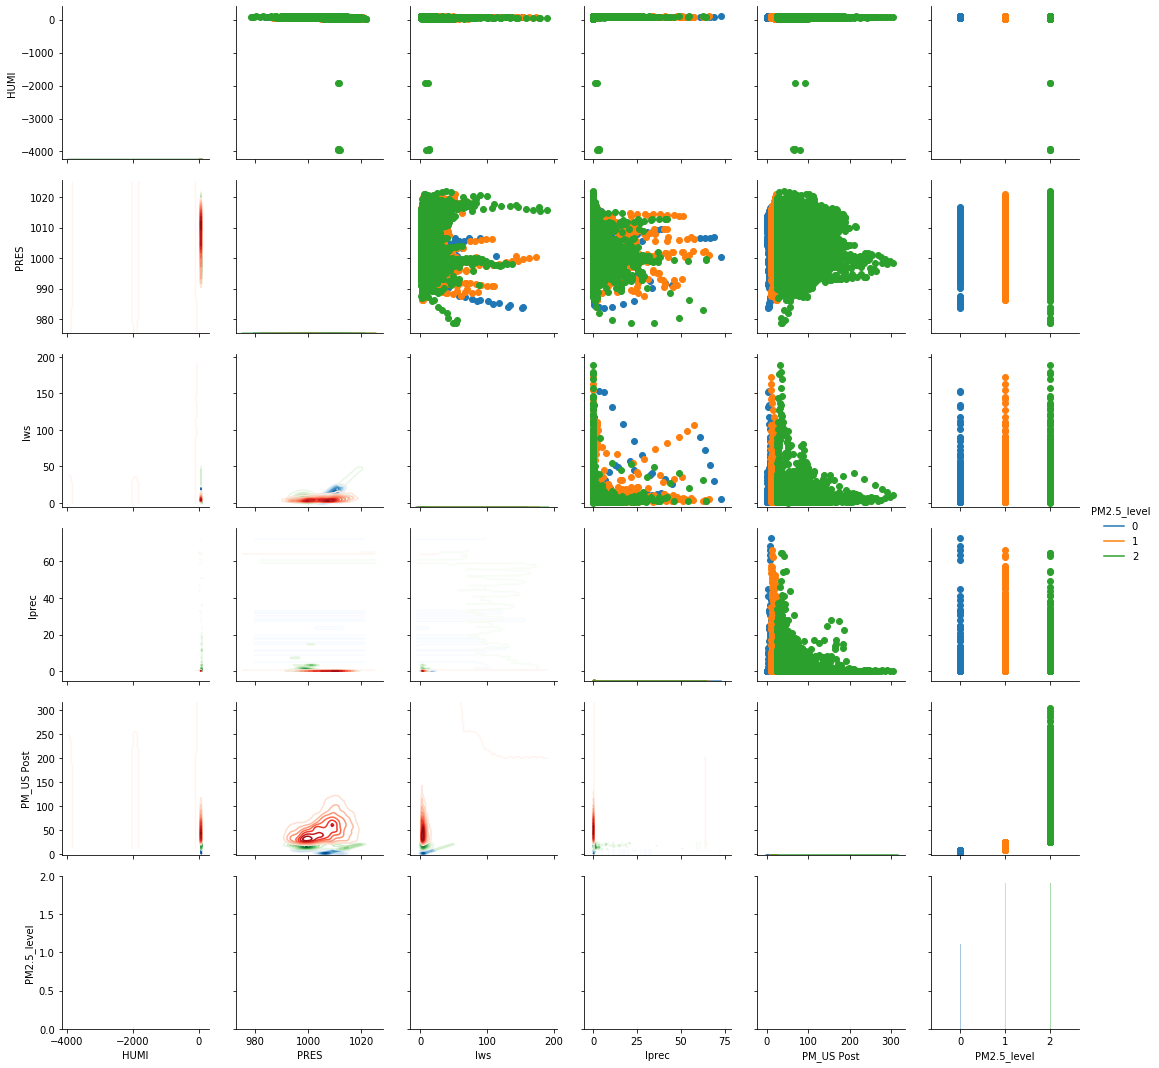

In [13]:
df3 = before_cleaning(data=df_Guangzhou)
df3 = clear_missing_and_duplicate_data(df=df3)
df3 = resample_rolling(df=df3)
df3

,Date,HUMI,PRES,Iws,Iprec,PM_US Post,PM2.5_level
4,2011-12-29 02:00:00,72.804,1027.9,16.1,0.000000e+00,33.5,2
5,2011-12-29 04:00:00,75.626,1028.0,20.7,0.000000e+00,32.5,2
6,2011-12-29 06:00:00,75.588,1028.1,26.0,0.000000e+00,31.7,2
7,2011-12-29 08:00:00,74.067,1028.5,32.1,0.000000e+00,34.5,2
8,2011-12-29 10:00:00,71.248,1028.9,39.1,0.000000e+00,36.6,2
...,...,...,...,...,...,...,...
17566,2015-12-31 14:00:00,61.986,1034.7,10.8,4.689582e-14,140.5,2
17567,2015-12-31 16:00:00,54.498,1034.8,10.3,4.689582e-14,119.3,2
17568,2015-12-31 18:00:00,50.267,1034.7,9.5,4.689582e-14,99.1,2
17569,2015-12-31 20:00:00,52.788,1034.6,10.7,4.689582e-14,89.4,2


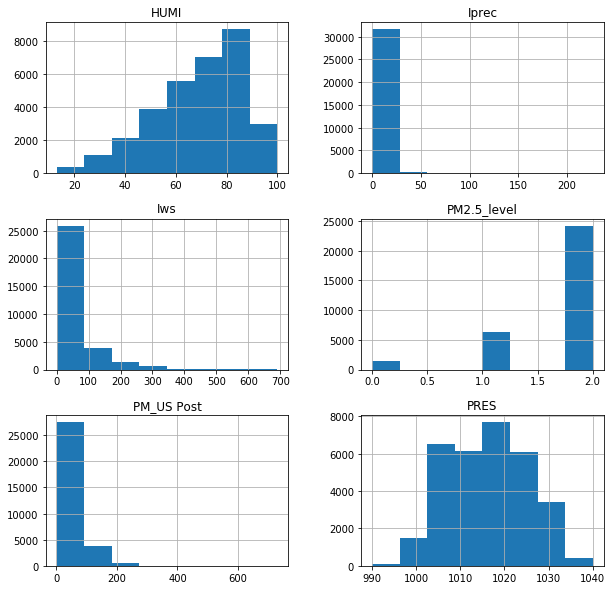

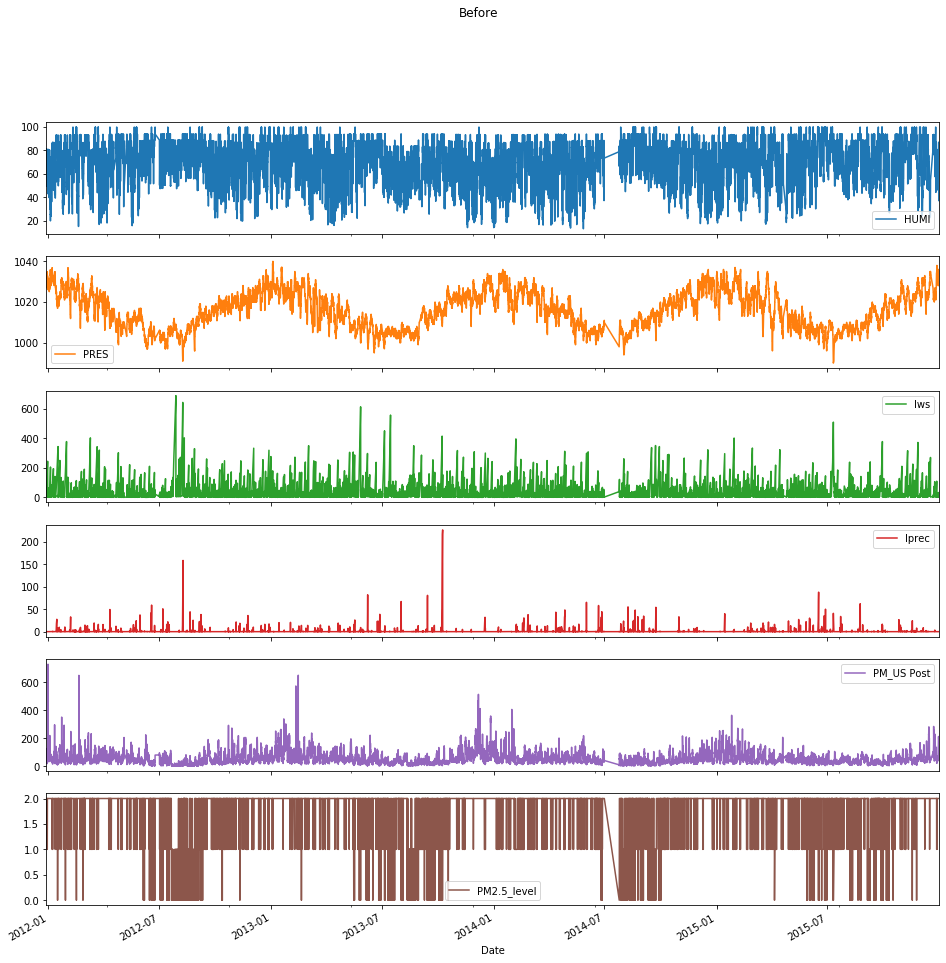

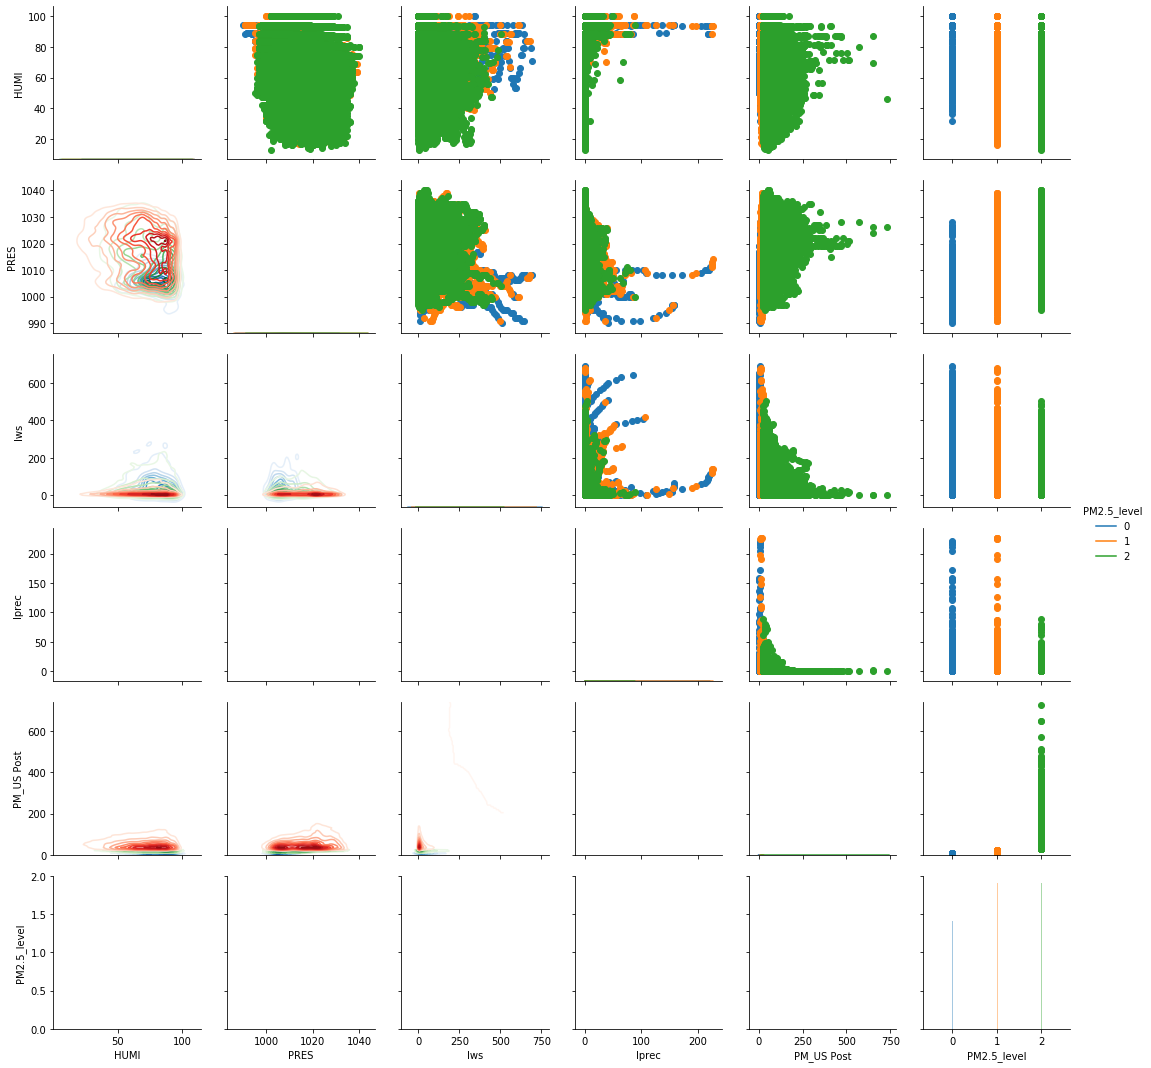

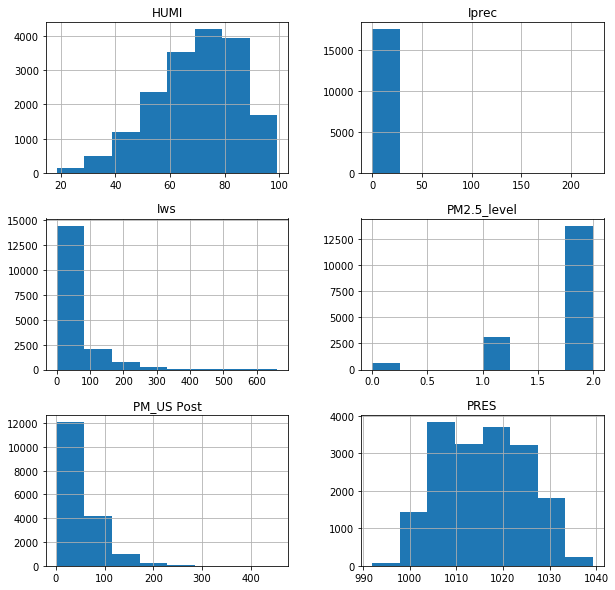

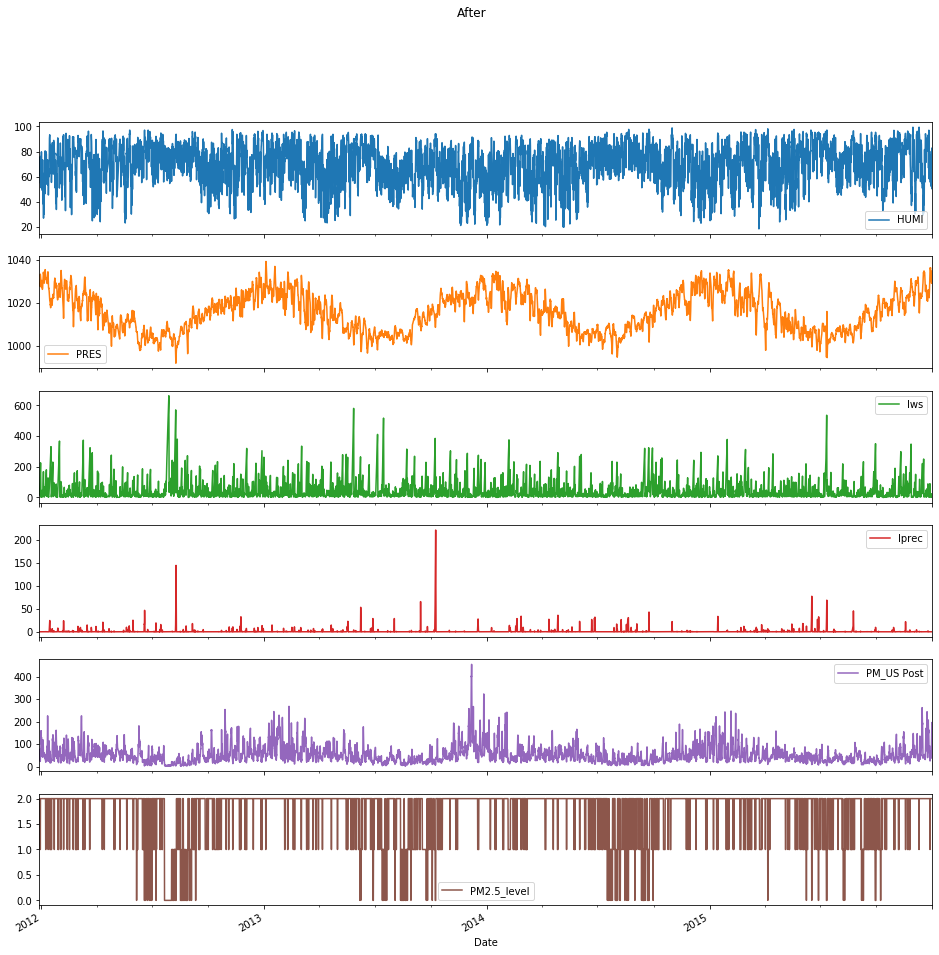

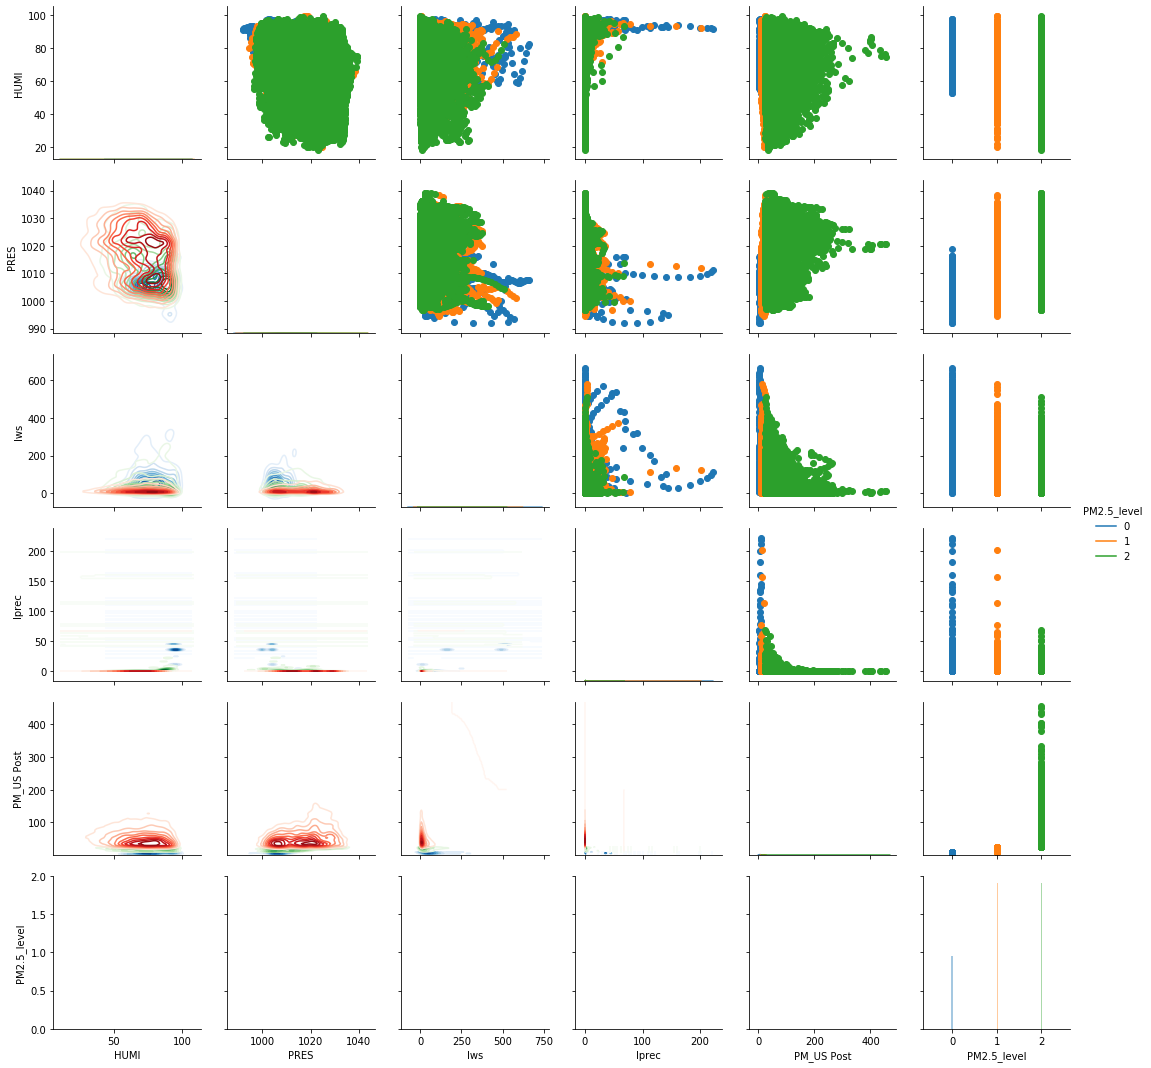

In [14]:
df4 = before_cleaning(data=df_Shanghai)
df4 = clear_missing_and_duplicate_data(df=df4)
df4 = resample_rolling(df=df4)
df4

,Date,HUMI,PRES,Iws,Iprec,PM_US Post,PM2.5_level
4,2013-04-22 20:00:00,25.934,1012.8,46.4,0.000000e+00,105.2,2
5,2013-04-22 22:00:00,25.956,1012.7,42.1,0.000000e+00,101.3,2
6,2013-04-23 00:00:00,25.978,1012.6,37.8,0.000000e+00,97.4,2
7,2013-04-23 02:00:00,26.000,1012.5,33.5,0.000000e+00,93.5,2
8,2013-04-23 04:00:00,26.022,1012.4,29.2,0.000000e+00,89.6,2
...,...,...,...,...,...,...,...
11797,2015-12-31 14:00:00,78.068,1032.9,3.8,1.524059e-14,301.7,2
11798,2015-12-31 16:00:00,72.323,1032.4,4.0,1.524059e-14,267.6,2
11799,2015-12-31 18:00:00,71.775,1031.8,4.0,1.524059e-14,229.3,2
11800,2015-12-31 20:00:00,71.134,1031.1,4.7,1.524059e-14,209.4,2


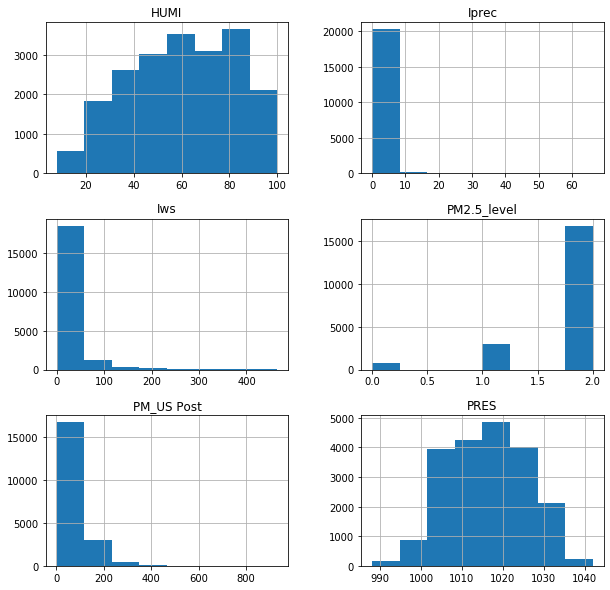

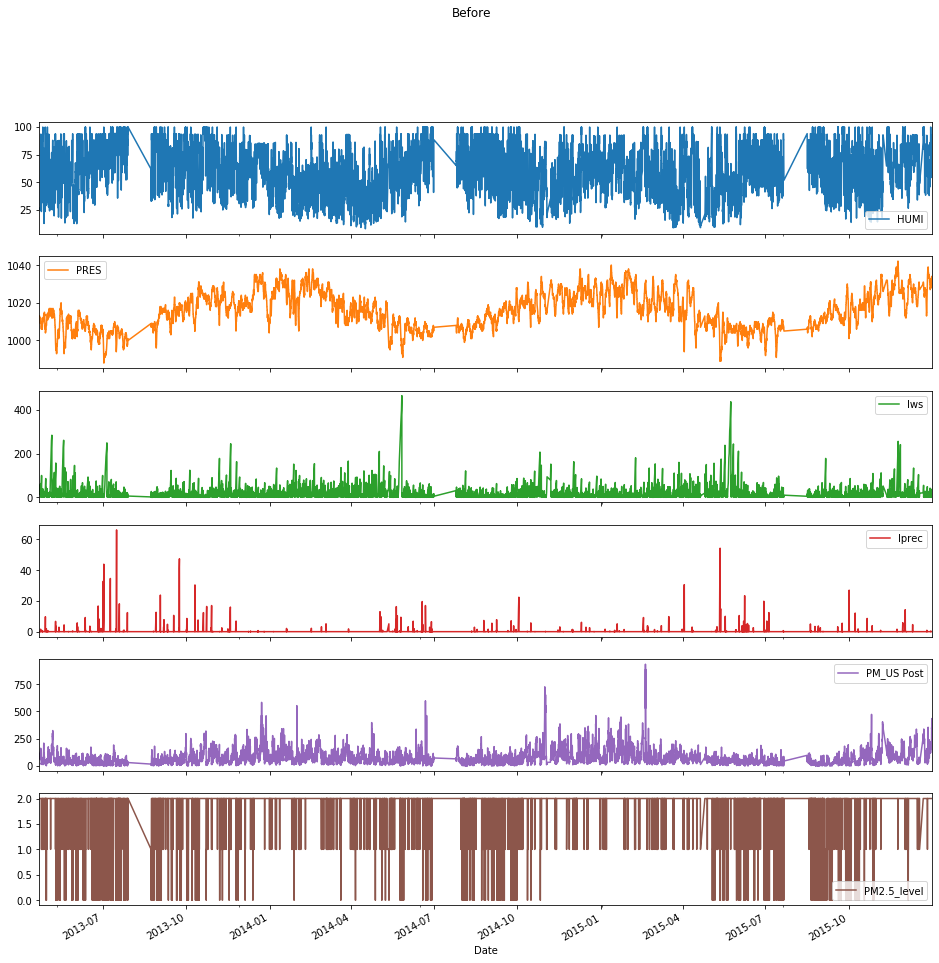

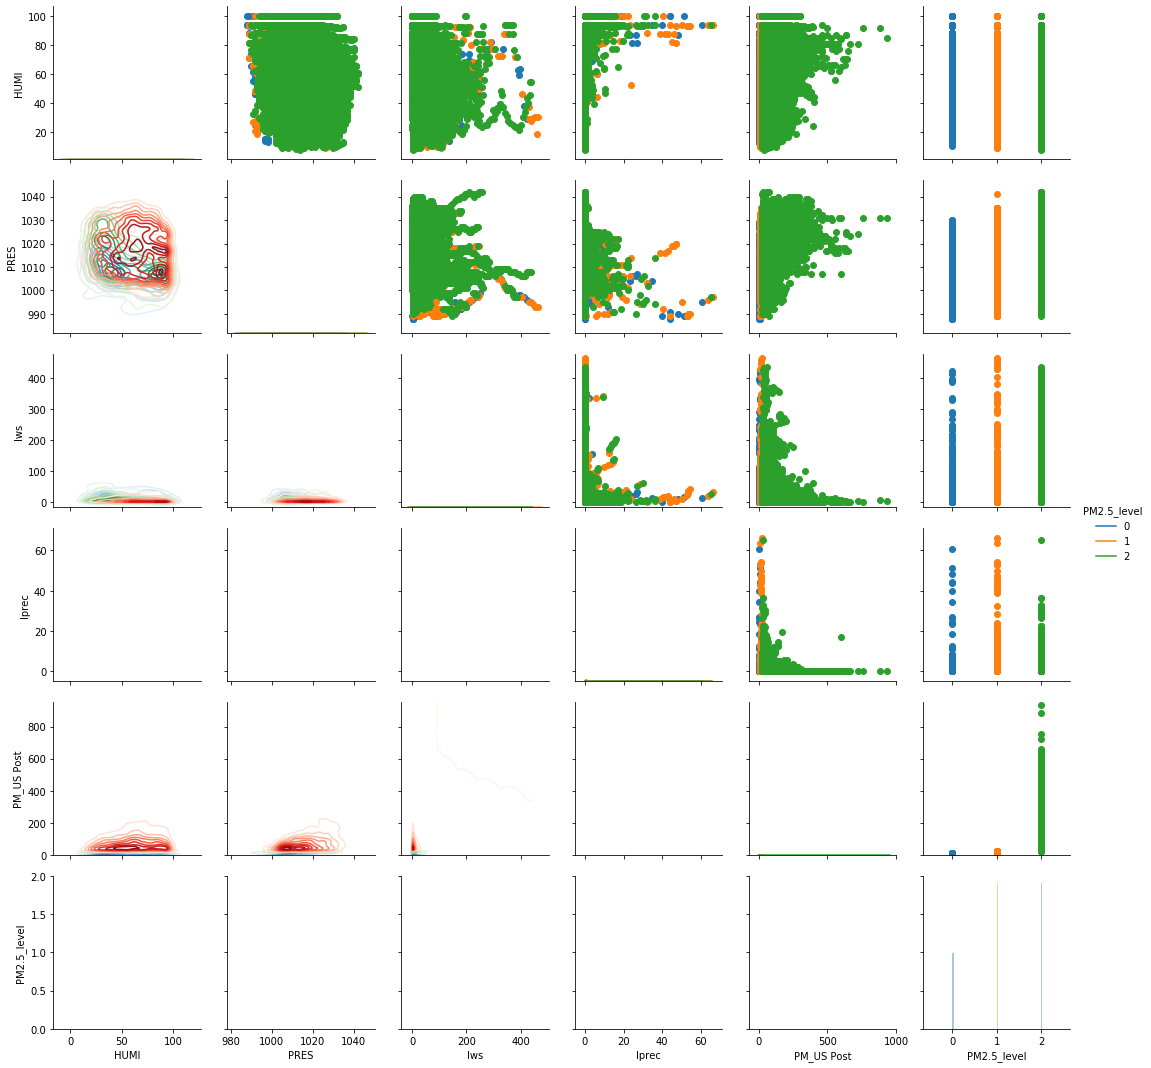

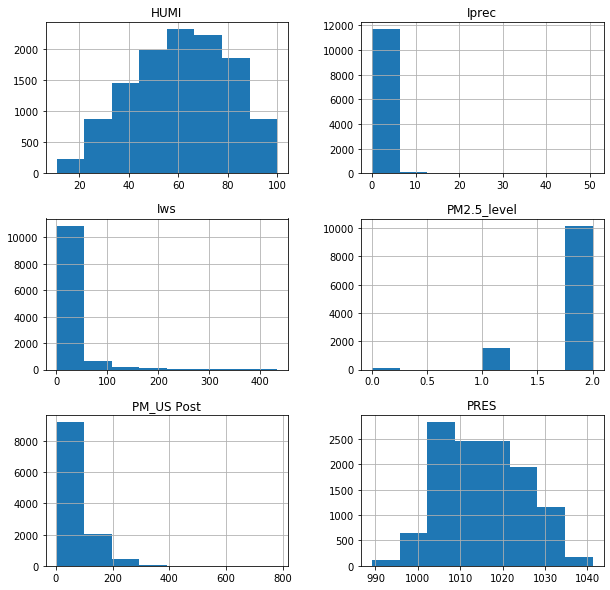

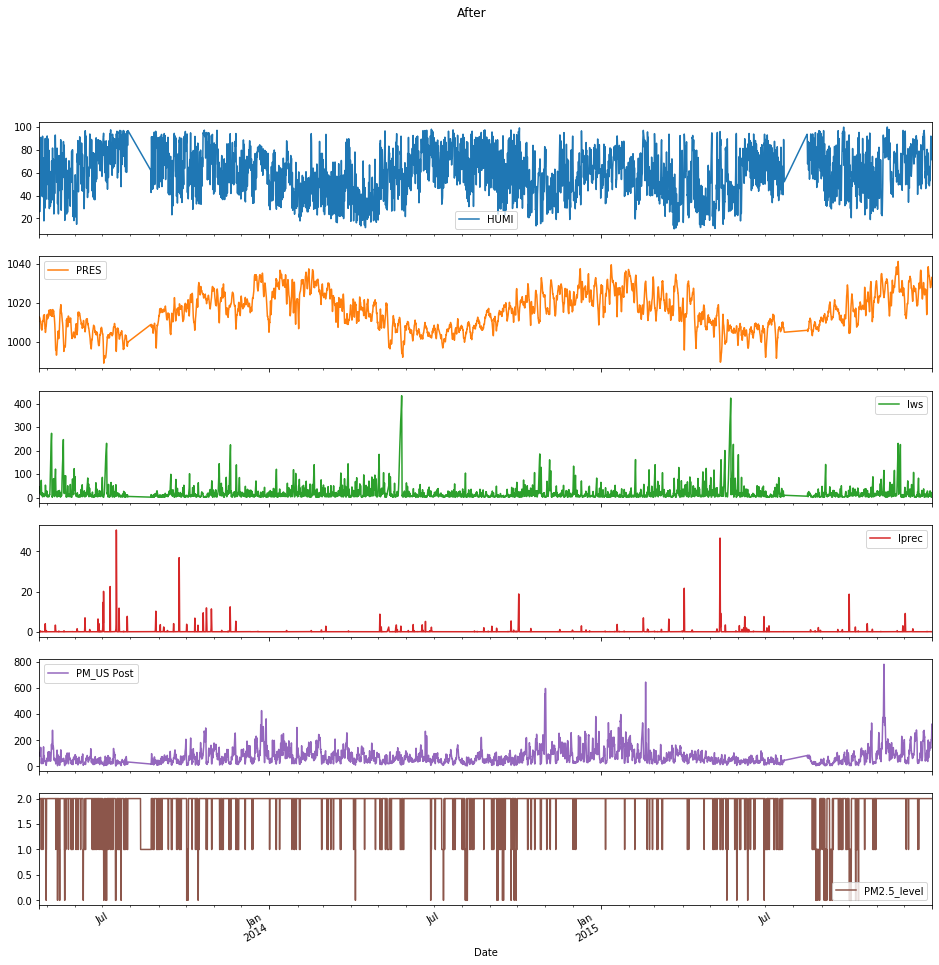

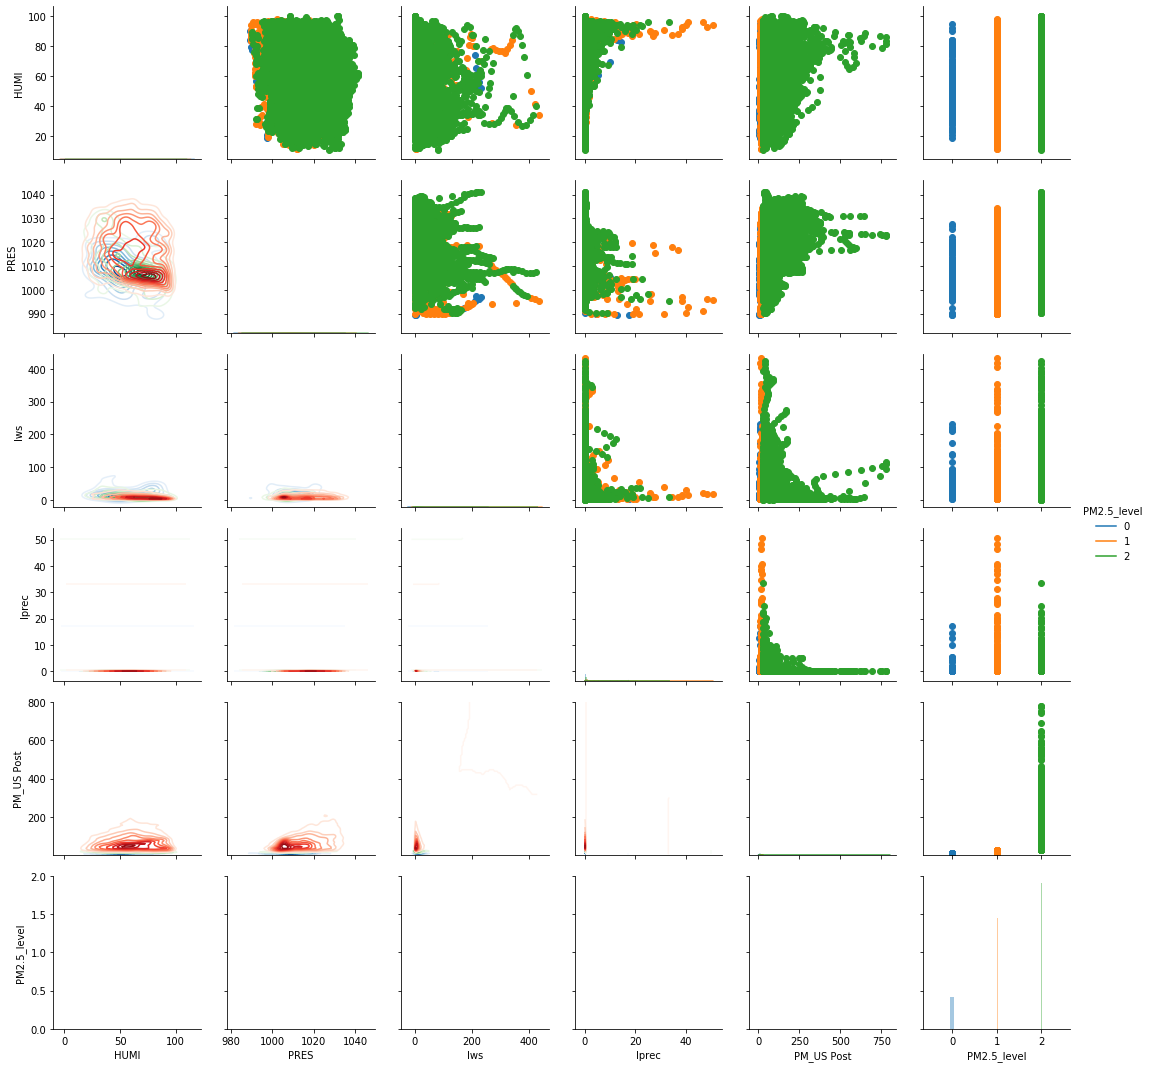

In [15]:
df5 = before_cleaning(data=df_Shenyang)
df5 = clear_missing_and_duplicate_data(df=df5)
df5 = resample_rolling(df=df5)
df5

In [16]:
df_all = [df1,df2,df3,df4,df5]

df = pd.concat(df_all)
df

,Date,HUMI,PRES,Iws,Iprec,PM_US Post,PM2.5_level
4,2010-01-02 06:00:00,66.450,1021.4,4.822,0.000000e+00,134.2,2
5,2010-01-02 08:00:00,75.250,1022.3,7.325,0.000000e+00,135.6,2
6,2010-01-02 10:00:00,83.650,1023.5,10.677,0.000000e+00,134.9,2
7,2010-01-02 12:00:00,84.600,1024.3,14.924,0.000000e+00,135.2,2
8,2010-01-02 14:00:00,81.500,1024.9,20.333,0.000000e+00,145.1,2
...,...,...,...,...,...,...,...
11797,2015-12-31 14:00:00,78.068,1032.9,3.800,1.524059e-14,301.7,2
11798,2015-12-31 16:00:00,72.323,1032.4,4.000,1.524059e-14,267.6,2
11799,2015-12-31 18:00:00,71.775,1031.8,4.000,1.524059e-14,229.3,2
11800,2015-12-31 20:00:00,71.134,1031.1,4.700,1.524059e-14,209.4,2


    1.3.3 Normalizing data

In [17]:
def min_max_norm(df):
    _df = df.iloc[:,1:5]
    print(_df)
    x = _df.values #returns a numpy array
    
    pm = df['PM2.5_level'].values
   
    min_max_scaler = preprocessing.MinMaxScaler() # Max-Min Norm
    x_min_max_scaled = min_max_scaler.fit_transform(x)
    
    _df = pd.DataFrame(x_min_max_scaled,columns=['HUMI','PRES','Iws','Iprec'])
    _df.plot()
    
    _df['PM2.5_level'] = pm
    return _df

         HUMI    PRES     Iws         Iprec
4      66.450  1021.4   4.822  0.000000e+00
5      75.250  1022.3   7.325  0.000000e+00
6      83.650  1023.5  10.677  0.000000e+00
7      84.600  1024.3  14.924  0.000000e+00
8      81.500  1024.9  20.333  0.000000e+00
...       ...     ...     ...           ...
11797  78.068  1032.9   3.800  1.524059e-14
11798  72.323  1032.4   4.000  1.524059e-14
11799  71.775  1031.8   4.000  1.524059e-14
11800  71.134  1031.1   4.700  1.524059e-14
11801  72.708  1030.2   6.000  1.524059e-14

[89569 rows x 4 columns]


,HUMI,PRES,Iws,Iprec,PM2.5_level
0,0.991698,0.637854,0.007284,0.000000e+00,2
1,0.993876,0.651267,0.011065,0.000000e+00,2
2,0.995954,0.669151,0.016128,0.000000e+00,2
3,0.996189,0.681073,0.022544,0.000000e+00,2
4,0.995422,0.690015,0.030715,0.000000e+00,2
...,...,...,...,...,...
89564,0.994573,0.809240,0.005740,1.524070e-19,2
89565,0.993151,0.801788,0.006042,1.524070e-19,2
89566,0.993016,0.792846,0.006042,1.524070e-19,2
89567,0.992857,0.782414,0.007100,1.524070e-19,2


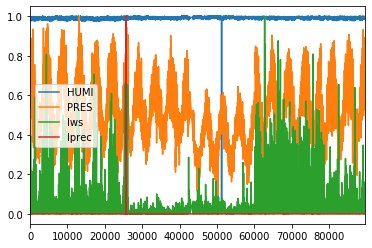

In [18]:
_df = min_max_norm(df=df)
_df

    1.3.4 Convert sample-based data to timeseries data format